In [101]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt # Visualization
import seaborn as sns # Visualization

from itertools import combinations

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [102]:
data = pd.read_csv('weather_prediction_dataset.csv')
labels = pd.read_csv('weather_prediction_bbq_labels.csv')

In [103]:
display(data.head(5))

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,20000102,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,20000103,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,20000104,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,20000105,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5


In [104]:
display(labels.head(5))

,DATE,BASEL_BBQ_weather,BUDAPEST_BBQ_weather,DE_BBQ_weather,DRESDEN_BBQ_weather,DUSSELDORF_BBQ_weather,HEATHROW_BBQ_weather,KASSEL_BBQ_weather,LJUBLJANA_BBQ_weather,MAASTRICHT_BBQ_weather,MALMO_BBQ_weather,MONTELIMAR_BBQ_weather,MUENCHEN_BBQ_weather,OSLO_BBQ_weather,PERPIGNAN_BBQ_weather,SONNBLICK_BBQ_weather,STOCKHOLM_BBQ_weather,TOURS_BBQ_weather
0,20000101,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,20000102,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,20000103,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,20000104,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,20000105,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [105]:
num_rows, num_columns = data.shape
print(f'Number of rows: {num_rows}')
print(f'Number of columns: {num_columns}')

Number of rows: 3654
Number of columns: 165


In [106]:
def assign_season(date):
    date_str = str(date)
    month = int(date_str[4:6])
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Autumn'
    else:
        return 'Winter'

In [107]:
data['Season'] = data['DATE'].apply(assign_season)

In [108]:
# Identify unique measurements across stations
measurements = set(col.split('_')[1] for col in data.columns if '_' in col)

# Define the operations to perform for each measurement
operations = ['mean', 'median', 'std']

# Automate aggregation
results = {}
for measure in measurements:
    columns_to_aggregate = [col for col in data.columns if measure in col]
    aggregated_data = data[columns_to_aggregate].agg(operations)
    results[measure] = aggregated_data

results_df = pd.concat(results, axis=1)

In [109]:
display(results_df)

precipitation                                                
       BASEL_precipitation BUDAPEST_precipitation DE_BILT_precipitation   
mean              0.234849               0.136442              0.236888  \
median            0.000000               0.000000              0.010000   
std               0.536267               0.408932              0.459495   

                                                                               
       DRESDEN_precipitation DUSSELDORF_precipitation HEATHROW_precipitation   
mean                0.175881                 0.218043               0.178279  \
median              0.000000                 0.010000               0.020000   
std                 0.459725                 0.439578               0.367572   

                                                                               
       KASSEL_precipitation LJUBLJANA_precipitation MAASTRICHT_precipitation   
mean               0.202211                0.367263                 0.220649  \
median             0.010000                0.000000                 0.010000   
std                0.407147                0.916321                 0.444137   

                            ...        pressure                      
       MALMO_precipitation  ... KASSEL_pressure LJUBLJANA_pressure   
mean              0.166732  ...        1.016373           1.017947  \
median            0.000000  ...        1.016500           1.017500   
std               0.395186  ...        0.009107           0.007704   

                                                                   
       MAASTRICHT_pressure MONTELIMAR_pressure MUENCHEN_pressure   
mean              1.016035            1.017094          1.017450  \
median            1.016300            1.017000          1.017200   
std               0.009313            0.006988          0.008226   

                                                                           
       OSLO_pressure PERPIGNAN_pressure ROMA_pressure STOCKHOLM_pressure   
mean        1.011396           1.016451      1.015247           1.011074  \
median      1.011600           1.016500      1.015300           1.012100   
std         0.012005           0.006809      0.006743           0.033838   

                       
       TOURS_pressure  
mean         1.016639  
median       1.017300  
std          0.018885  

[3 rows x 174 columns]

In [110]:
display(results_df['precipitation'])

,BASEL_precipitation,BUDAPEST_precipitation,DE_BILT_precipitation,DRESDEN_precipitation,DUSSELDORF_precipitation,HEATHROW_precipitation,KASSEL_precipitation,LJUBLJANA_precipitation,MAASTRICHT_precipitation,MALMO_precipitation,MONTELIMAR_precipitation,MUENCHEN_precipitation,OSLO_precipitation,PERPIGNAN_precipitation,SONNBLICK_precipitation,STOCKHOLM_precipitation,TOURS_precipitation
mean,0.234849,0.136442,0.236888,0.175881,0.218043,0.178279,0.202211,0.367263,0.220649,0.166732,0.253426,0.261700,0.239792,0.150733,0.541475,0.149039,0.186100
median,0.000000,0.000000,0.010000,0.000000,0.010000,0.020000,0.010000,0.000000,0.010000,0.000000,0.000000,0.010000,0.000000,0.000000,0.180000,0.000000,0.000000
std,0.536267,0.408932,0.459495,0.459725,0.439578,0.367572,0.407147,0.916321,0.444137,0.395186,0.910761,0.599618,0.512402,0.772949,0.771348,0.345369,0.422151


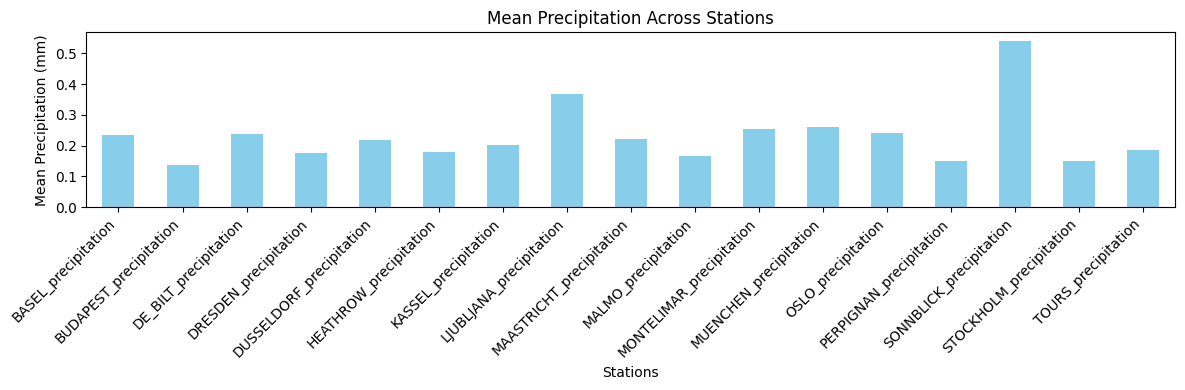

In [111]:
# Plotting the data
plt.figure(figsize=(12, 4))  # Adjust figure size to ensure labels fit well
ax = results_df['precipitation'].iloc[0].plot(kind='bar', color='skyblue')
ax.set_title('Mean Precipitation Across Stations')
ax.set_ylabel('Mean Precipitation (mm)')
ax.set_xlabel('Stations')

# Rotate labels to prevent overlap
plt.xticks(rotation=45, ha='right')  # Rotate labels slightly and align right for better fit

# Adjust font size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout() # Enhance readability
plt.show()

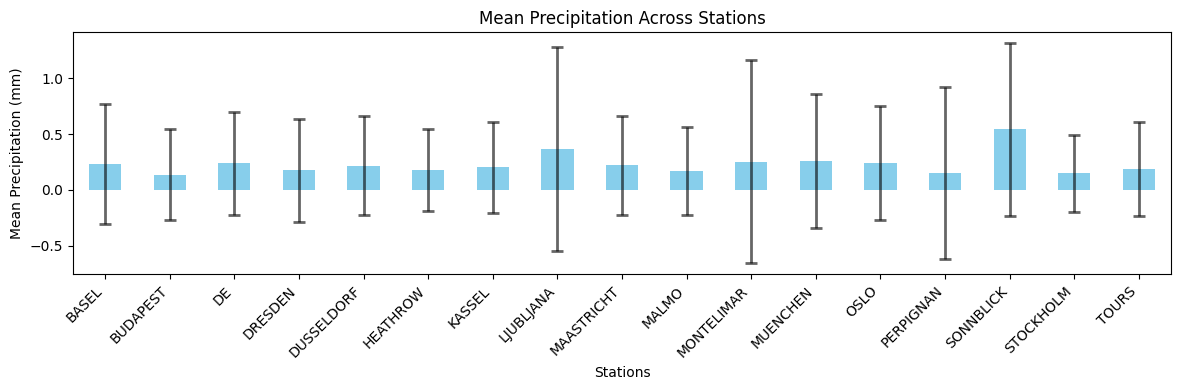

In [118]:
stations = [col.split('_')[0] for col in results_df['precipitation'].columns if '_' in col]

# Assuming results_df is already defined and contains the precipitation data
means = results_df['precipitation'].iloc[0].values
medians = results_df['precipitation'].iloc[1].values
st_devs = results_df['precipitation'].iloc[2].values

# Plotting the data
plt.figure(figsize=(12, 4))  # Adjust figure size to ensure labels fit well
ax = results_df['precipitation'].iloc[0].plot(
    kind='bar', color='skyblue', yerr=st_devs, capsize=4,  # capsize adds horizontal lines at the error bar tops
    error_kw={'capthick': 2, 'elinewidth': 2, 'alpha': 0.6}  # Customize error bars for better visibility
)
ax.set_title('Mean Precipitation Across Stations')
ax.set_ylabel('Mean Precipitation (mm)')
ax.set_xlabel('Stations')

# Rotate labels to prevent overlap
ax.set_xticklabels(stations, rotation=45, ha='right') # Rotate labels slightly and align right for better fit

# Adjust font size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()  # Enhance readability
plt.show()


# Exploratory Data Analysis
- Statistical Summary: Review basic statistics (mean, median, mode, standard deviation, etc) to understand distributions and detect any anomalies or outliers.
- Trend Analysis: Look for trends over time, such as increasing temperatures or changing precipitation patterns
- Seasonality: Check for seasonal patterns in variables like temperature and humidity. Seasonal decomposition of time series (using STL decomposition) can help model this.

# Feature Engineering
- Temporal Features: Create new features with time stamps such as year, month, day, hour, and day of the week

- Lag Features: Determine the optimal number of lags based on autocorrelation plots

- Rolling statistics: Generate rolling mean and standard deviation over various window sizes to smooth out short-term fluctuations and highlight longer-term trends

- Weather Indicies: Heat index and Wind Chill Factor may be calcualted from basic measurements given in the data set and can be highly predictive

# Additional Notes
- Use time series plots to visualize the data
- Individual variables and outliers can be spotted using histograms and box plots
- Heatmaps can visualizae the correlation matrix of the features
- May need to normalize/standardize data depending on the model used
- Consider PCA to reduce the dimensionality of the dataset (may not be necessary)
- Start with naive forecasting (predicting the next value as the same as the last observe value) to set a performance benchmark